In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:

# dataset
file_path = './Data/OROV.csv'  # Update this path
df = pd.read_csv(file_path)
df.index.freq = 'MS'

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()


,T,V,P,F
Date,,,,
1920-01-01,32.00,2.11,12.58,849.0
1920-02-01,36.43,3.94,3.63,562.0
1920-03-01,40.82,4.93,4.47,960.0
1920-04-01,43.38,6.60,0.86,743.0
1920-05-01,47.98,6.91,2.26,831.0


In [3]:
def scale_data(data, feature_range=(0.1, 0.9)):
    scaler = MinMaxScaler(feature_range=feature_range)
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler


train_df = df[df.index < pd.Timestamp('2015-01-01')]

train_scaled, scaler = scale_data(train_df)

# function sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  # Using 12 months as the sequence length

# train and test datasets
X_train, y_train = create_sequences(train_scaled, seq_length)




In [5]:
# the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, 4), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(25, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=0)

In [10]:
def select_year_data(df, year):
    start_date = pd.Timestamp(f'{year-1}-01-01')
    end_date = pd.Timestamp(f'{year}-10-01')
    return df[(df.index >= start_date) & (df.index < end_date)]



1/1 [==============================] - 0s 25ms/step


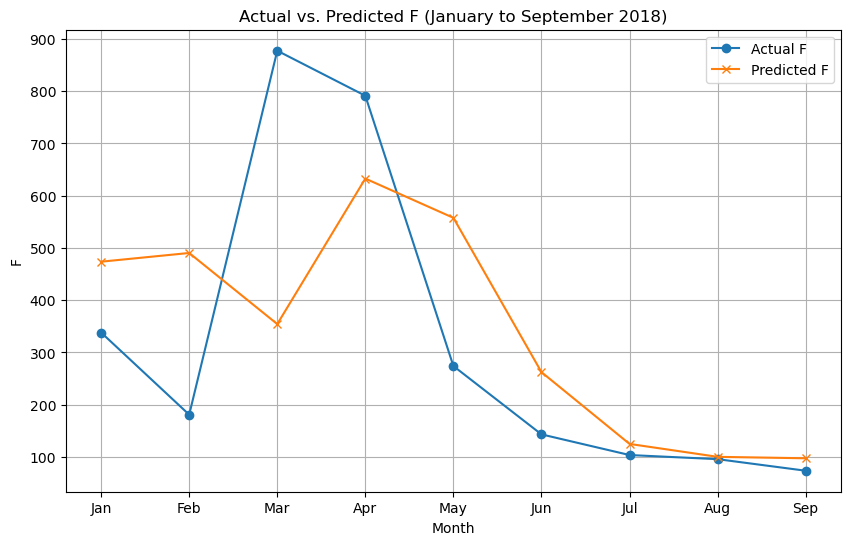

Accumulated Actual F (Jan to Sep 2018): 2877.37
Accumulated Predicted F (Jan to Sep 2018): 3093.10


In [13]:
###############################################################################################################
year_to_analyze =2018
###############################################################################################################
test_df = select_year_data(df, year_to_analyze)
# Extract start and end year for dynamic output
start_year = test_df.index.min().year
end_year = test_df.index.max().year

test_scaled = scaler.transform(test_df)  

# function sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  # Using 12 months as the sequence length

X_test, y_test = create_sequences(test_scaled, seq_length)

# Make predictions
predictions_scaled = model.predict(X_test)

# Invert scaling
predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions_scaled), axis=1))[:, -1]

# Invert scaling for actual y_test values for comparison
actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Calculate accumulated "F" for actual and predicted
accumulated_actual_F = np.sum(actual)
accumulated_predicted_F = np.sum(predictions)

# Plot actual vs predicted "Flow"
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual F', marker='o')
plt.plot(predictions, label='Predicted F', marker='x')
plt.title(f'Actual vs. Predicted F (January to September {end_year})')  
plt.xlabel('Month')
plt.ylabel('F')
plt.xticks(ticks=np.arange(9), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()
plt.grid(True)
plt.show()

print(f"Accumulated Actual F (Jan to Sep {end_year}): {accumulated_actual_F:.2f}")
print(f"Accumulated Predicted F (Jan to Sep {end_year}): {accumulated_predicted_F:.2f}")
